In [14]:
"""
directory structure

backtracer.ipynb
kabu_plus/
 |- japan-all-stock-data/                            # 07_投資指標データ
    |- daily/
       |- japan-all-stock-data_20210301.csv
       |- *.csv
       ...
 |- japan-all-stock-prices-2/                        # 02_株価一覧表（詳細フォーマット）
    |- daily/
       ...
 |- tosho-stock-ohlc/                                # 06_株価四本値データ（日通し・前場・後場）
    |- daily/
       ... 
 |- japan-all-stock-margin-transactions/             # 10_信用取引残高データ
    |- weekly/
       ... 
"""

base_filepath = 'kabu_plus/'

all_stock_data_filepath = 'japan-all-stock-data/daily/'
japan_all_stock_prices_2_filepath = 'japan-all-stock-prices-2/daily/'
tosho_stock_ohlc_filepath = 'tosho-stock-ohlc/daily/'

japan_all_stock_margin_transactions_filepath = 'japan-all-stock-margin-transactions/weekly/'

japan_all_stock_financial_results_filepath = 'japan-all-stock-financial-results/monthly/'

In [2]:
import glob
    
def get_all_filename_list(topic_filepath):
    return glob.glob(base_filepath + topic_filepath + "*")

In [233]:
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import mplfinance as mpf
import numpy as np
import matplotlib.pyplot as plt

def create_dataframe_from(file_list):
    df = pd.DataFrame()
    for file in tqdm(file_list):
        df_tmp = pd.read_csv(file, encoding="shift-jis")
        
        try:
            dtime = file.split('.')[0][-8:]
            df_tmp['datetime'] = datetime.strptime(dtime, '%Y%m%d')
        except:
            print(file + " has failed to be read")
            continue
        
        df = pd.concat([df, df_tmp])
    return df

In [9]:
def create_sc_datetime_column(file_list):
    def convert_to_numeric_dtype(df, key):
        try:
            df[key] = df.apply(lambda x: float(x[key]), 1)
            df[key] = df[key].apply(pd.to_numeric)        
        except:
            pass
        return df
    df = create_dataframe_from(file_list)
    df = df.sort_values(by=["datetime", "SC"])
        
    # library使用のためrename
    df = df.rename(columns={'高値': 'High', '安値': 'Low', '始値': 'Open', '終値': 'Close', '出来高': 'Volume'})
    
    df = convert_to_numeric_dtype(df, 'High')
    df = convert_to_numeric_dtype(df, 'Low')
    df = convert_to_numeric_dtype(df, 'Open')
    df = convert_to_numeric_dtype(df, 'Close')
    
    try:
        key = 'EPS（予想）'
        df[key] = df[key].replace('-', np.nan)    
        df = convert_to_numeric_dtype(df, key)
        
        key = 'BPS（実績）'
        df[key] = df[key].replace('-', np.nan)
        df = convert_to_numeric_dtype(df, key)
    
        key = 'PBR（実績）'
        df[key] = df[key].replace('-', np.nan)
        df = convert_to_numeric_dtype(df, key)
    
        key = 'PER（予想）'
        df[key] = df[key].replace('-', np.nan)
        df = convert_to_numeric_dtype(df, key)
    except:
        pass
    
    # indexを銘柄+datetimeに変更 (ユニークにする)
    df = df.reset_index()
    df = df.drop(columns=["index"])
    df['SC_datetime'] = df.apply(lambda x: str(x['SC']) + "_" + str(x['datetime']), 1)
    df = df.set_index('SC_datetime')
    return df

In [42]:
file_list = get_all_filename_list(all_stock_data_filepath)

df = create_sc_datetime_column(file_list)

100%|██████████| 266/266 [00:46<00:00,  5.72it/s]


In [10]:
file_list = get_all_filename_list(japan_all_stock_prices_2_filepath)

df_prices = create_sc_datetime_column(file_list)

100%|██████████| 266/266 [03:13<00:00,  1.37it/s]


In [11]:
file_list = get_all_filename_list(tosho_stock_ohlc_filepath)

df_ohlc = create_sc_datetime_column(file_list)

100%|██████████| 266/266 [00:43<00:00,  6.06it/s]


In [12]:
file_list = get_all_filename_list(japan_all_stock_margin_transactions_filepath)

df_margin = create_sc_datetime_column(file_list)

100%|██████████| 57/57 [00:01<00:00, 49.75it/s]


In [15]:
file_list = get_all_filename_list(japan_all_stock_financial_results_filepath)

df_financial = create_sc_datetime_column(file_list)

 73%|███████▎  | 11/15 [00:00<00:00, 27.60it/s]

kabu_plus/japan-all-stock-financial-results/monthly/japan-all-stock-financial-results.csv has failed to be read


100%|██████████| 15/15 [00:00<00:00, 28.61it/s]


In [16]:
key = 'EPS（予想）'
df[key] = df[key].replace('-', np.nan)
df[key] = df[key].apply(pd.to_numeric)

In [17]:
key = 'BPS（実績）'
df[key] = df[key].replace('-', np.nan)
df[key] = df[key].apply(pd.to_numeric)

In [131]:
key = '配当利回り（予想）'
df[key] = df[key].replace('-', np.nan)
df[key] = df[key].apply(pd.to_numeric)

In [18]:
# 自己資本比率
# ROE = EPS（一株当たり利益）÷ BPS（一株当たり純資産）× 100
# https://www.nomura.co.jp/terms/english/r/roe.html

#df['ROE'] = df['EPS（予想）'] / df['BPS（実績）'] * 100
#del df['ROE']

In [19]:
df_margin.columns

Index(['SC', '信用買残高', '信用買残高 前週比', '信用売残高', '信用売残高 前週比', '貸借倍率', 'datetime'], dtype='object')

In [22]:
df_financial.columns

Index(['SC', '名称', '決算期', '決算発表日（本決算）', '売上高（百万円）', '営業利益（百万円）', '経常利益（百万円）',
       '当期利益（百万円）', '総資産（百万円）', '自己資本（百万円）', '資本金（百万円）', '有利子負債（百万円）',
       '自己資本比率', 'ROE', 'ROA', '発行済株式数', 'datetime'],
      dtype='object')

In [50]:
df = df.merge(df_financial.drop(columns=['datetime', 'SC', '名称', '発行済株式数']), left_on='SC_datetime', right_on='SC_datetime', how='outer')

In [63]:
delete_columns = ['SC', '市場', 'datetime']

# 重複column　の排除
df = pd.merge(df.drop(columns=delete_columns), df_ohlc, left_index=True, right_index=True)
df

,名称,業種,時価総額（百万円）,発行済株式数,配当利回り（予想）,1株配当（予想）,PER（予想）,PBR（実績）,EPS（予想）,BPS（実績）,...,売買代金,前場始値,前場高値,前場安値,前場終値,後場始値,後場高値,後場安値,後場終値,datetime
SC_datetime,,,,,,,,,,,,,,,,,,,,,
1301_2021-03-01 00:00:00,極洋,水産・農林,33277,10928283,2.3,70,10.91,0.85,279.01,3570.06,...,69759000,3005,3045,3005,3035,3040,3060,3025,3045,2021-03-01
1332_2021-03-01 00:00:00,日本水産,水産・農林,161839,312430277,1.64,8.5,14.02,0.98,36.96,529.68,...,776756300,511,514,505,512,512,519,511,518,2021-03-01
1333_2021-03-01 00:00:00,マルハニチロ,水産・農林,133854,52656910,1.57,40,20.90,0.94,121.62,2693.94,...,547659900,2484,2498,2469,2497,2491,2549,2491,2542,2021-03-01
1352_2021-03-01 00:00:00,ホウスイ,卸売,8278,8379000,2.02,20,13.79,1.22,71.65,810.44,...,1673800,988,988,974,974,980,988,980,988,2021-03-01
1375_2021-03-01 00:00:00,雪国まいたけ,水産・農林,72527,39850000,2.31,42,14.22,8.41,127.95,216.31,...,254621100,1769,1797,1768,1794,1793,1824,1791,1820,2021-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993_2022-03-30 00:00:00,ヤマザワ,小売,18085,10960825,1.64,27,35.97,0.62,45.87,2641.08,...,4099500,1646,1646,1623,1623,1623,1650,1623,1650,2022-03-30
9994_2022-03-30 00:00:00,やまや,小売,27196,10847870,1.91,48,6.18,1.00,405.84,2509.49,...,186702900,2524,2524,2481,2484,2484,2507,2475,2507,2022-03-30
9995_2022-03-30 00:00:00,グローセル,卸売,11205,26426800,2.83,12,NaN,0.48,-23.35,887.37,...,145631500,427,427,421,422,422,427,422,424,2022-03-30


In [77]:
financial_columns = ['決算期', '決算発表日（本決算）', '売上高（百万円）', '営業利益（百万円）', '経常利益（百万円）',
       '当期利益（百万円）', '総資産（百万円）', '自己資本（百万円）', '資本金（百万円）', '有利子負債（百万円）',
       '自己資本比率', 'ROE', 'ROA'
]

for sc in tqdm(df['SC'].unique()):
    for col in financial_columns:
        df.loc[df['SC'] == sc, col] = df[df['SC'] == sc][col].fillna(method='ffill')

df[df['SC'] == sc][col]

100%|██████████| 3875/3875 [16:52<00:00,  3.83it/s]


SC_datetime
9219_2022-03-30 00:00:00    NaN
Name: ROA, dtype: object

In [79]:
print(len(df))
print(len(df.dropna()))

995759
837653


AxesSubplot(0.125,0.125;0.775x0.755)


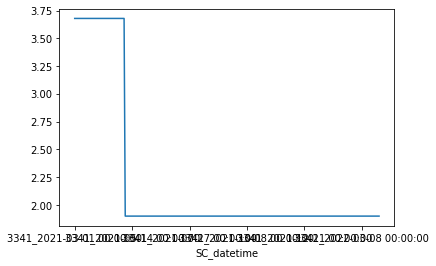

In [76]:
print(df[df['SC'] == sc][col].apply(pd.to_numeric).plot())

In [80]:
keys = ['PBR（実績）', 'PER（予想）', '時価総額（百万円）', '自己資本比率', 'ROE', 'ROA']
for key in tqdm(keys):
    df[key] = df[key].replace('-', np.nan) 
    df[key] = df[key].apply(pd.to_numeric)

100%|██████████| 6/6 [01:16<00:00, 12.83s/it]


In [128]:
df.columns

Index(['名称', '業種', '時価総額（百万円）', '発行済株式数', '配当利回り（予想）', '1株配当（予想）', 'PER（予想）',
       'PBR（実績）', 'EPS（予想）', 'BPS（実績）', '最低購入額', '単元株', '高値日付', '年初来高値',
       '安値日付', '年初来安値', '決算期', '決算発表日（本決算）', '売上高（百万円）', '営業利益（百万円）',
       '経常利益（百万円）', '当期利益（百万円）', '総資産（百万円）', '自己資本（百万円）', '資本金（百万円）',
       '有利子負債（百万円）', '自己資本比率', 'ROE', 'ROA', 'SC', '日付', 'Open', 'High', 'Low',
       'Close', 'VWAP', 'Volume', '売買代金', '前場始値', '前場高値', '前場安値', '前場終値',
       '後場始値', '後場高値', '後場安値', '後場終値', 'datetime'],
      dtype='object')

In [135]:
df['配当利回り（予想）'].value_counts()

0.00     145629
2.00       2677
2.33       2626
1.79       2556
1.72       2543
          ...  
14.13         1
8.26          1
11.25         1
13.41         1
10.26         1
Name: 配当利回り（予想）, Length: 1129, dtype: int64

In [253]:
df[(df['datetime'] == '2022-03-01') & \
   (df['PBR（実績）'] <= 1) & \
   (df['PER（予想）'] <= 30) & \
   (df['時価総額（百万円）'] <= 10000) & \
   (df['自己資本比率'] >= 60)  \
   & (df['配当利回り（予想）'] >= 5.0) \
  ][['SC']]

,SC
SC_datetime,
7847_2022-03-01 00:00:00,7847


In [287]:
stock_num = 1717

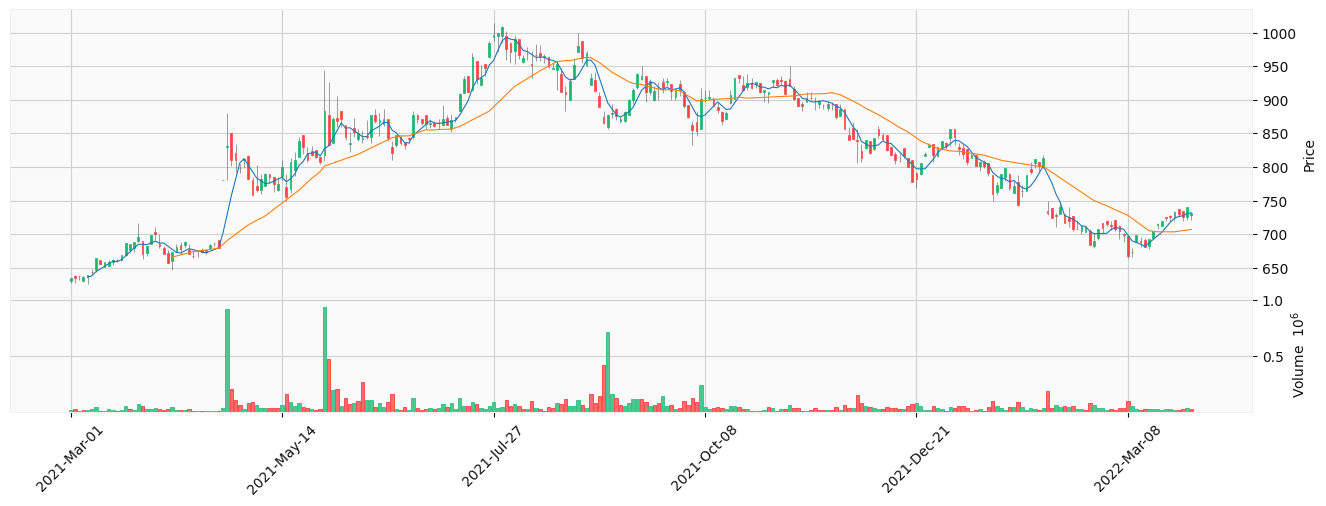

In [288]:
df_specific = df[df['SC'] == stock_num]

df_specific = df_specific.reset_index()
df_specific['datetime'] = df_specific.apply(lambda x: datetime.strptime(str(x['datetime']), '%Y-%m-%d %H:%M:%S'), 1)
df_specific = df_specific.set_index('datetime')

def change_to_numeric(df, key):
    df[key] = df[key].replace('-', np.nan) 
    df[key] = df[key].apply(pd.to_numeric)
    return df

change_to_numeric(df_specific, 'Open')
change_to_numeric(df_specific, 'Close')
change_to_numeric(df_specific, 'High')
change_to_numeric(df_specific, 'Low')
change_to_numeric(df_specific, 'Volume')
mpf.plot(df_specific, type='candle', volume=True, mav=(5, 25), figratio=(12,4), style='yahoo')

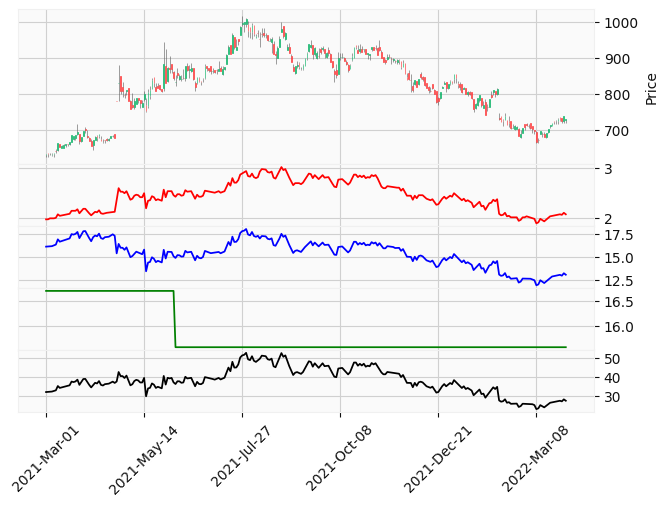

In [289]:
df_specific['PBR（実績）'] = df_specific['PBR（実績）'].apply(pd.to_numeric)
df_specific['PER（予想）'] = df_specific['PER（予想）'].apply(pd.to_numeric)
df_specific['PBR*PER'] = df_specific['PBR（実績）'] * df_specific['PER（予想）']

add_plot_list = [
    mpf.make_addplot(df_specific['PBR（実績）'], color='r', panel=1, secondary_y=False),
    mpf.make_addplot(df_specific['PER（予想）'], color='b', panel=2, secondary_y=False),
    mpf.make_addplot(df_specific['ROE'], color='g', panel=3, secondary_y=False),
    mpf.make_addplot(df_specific['PBR*PER'], color='black', panel=4, secondary_y=False)
]

mpf.plot(df_specific, type='candle', style='yahoo', addplot=add_plot_list)

In [290]:
df_specific['PER（予想）'].mean()

15.421165413533837

In [291]:
df_specific['PBR（実績）'].mean()

2.4497744360902254

bought : {'price': 781, 'SC': 1717, 'datetime': '2021-04-30 00:00:00'}
sold   : {'price': 765, 'SC': 1717, 'datetime': '2021-05-06 00:00:00'}
bought : {'price': 770, 'SC': 1717, 'datetime': '2021-05-17 00:00:00'}
sold   : {'price': 807, 'SC': 1717, 'datetime': '2021-05-18 00:00:00'}
bought : {'price': 767, 'SC': 1717, 'datetime': '2021-05-18 00:00:00'}
sold   : {'price': 811, 'SC': 1717, 'datetime': '2021-05-19 00:00:00'}
bought : {'price': 795, 'SC': 1717, 'datetime': '2021-05-19 00:00:00'}
sold   : {'price': 839, 'SC': 1717, 'datetime': '2021-05-20 00:00:00'}
bought : {'price': 815, 'SC': 1717, 'datetime': '2021-05-20 00:00:00'}
sold   : {'price': 830, 'SC': 1717, 'datetime': '2021-05-21 00:00:00'}
bought : {'price': 847, 'SC': 1717, 'datetime': '2021-05-21 00:00:00'}
sold   : {'price': 810, 'SC': 1717, 'datetime': '2021-05-24 00:00:00'}
bought : {'price': 821, 'SC': 1717, 'datetime': '2021-05-24 00:00:00'}
sold   : {'price': 818, 'SC': 1717, 'datetime': '2021-05-25 00:00:00'}
bought

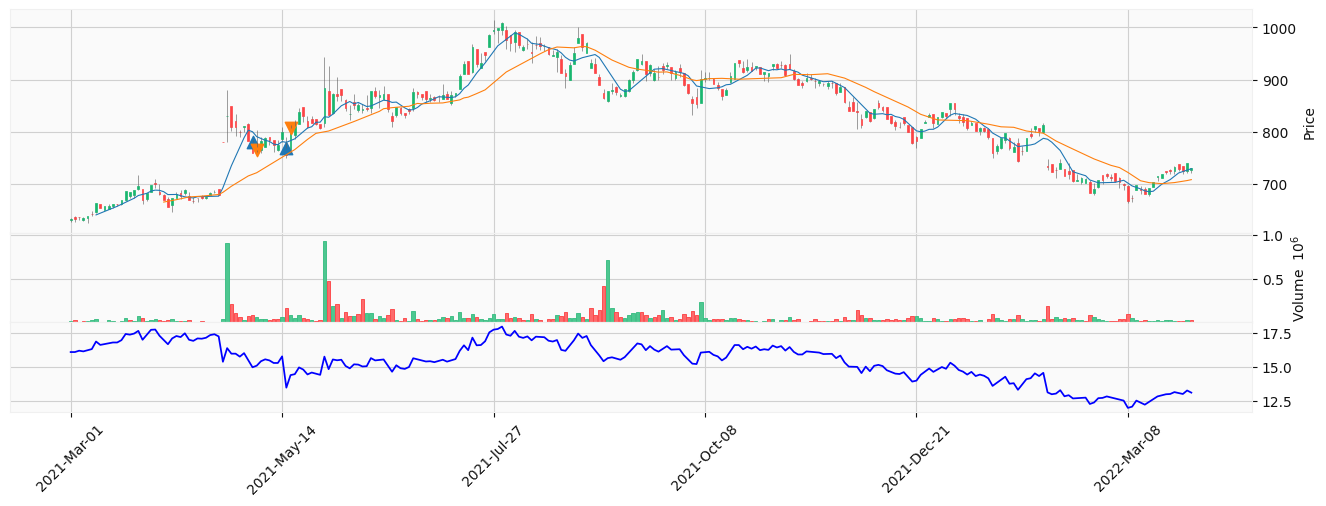

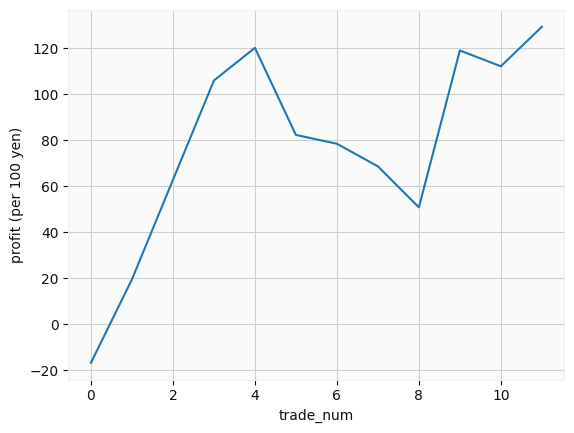

12922.800000000001


In [300]:
class BacktestSimulator:
    def __init__(self, df, initial_amount, commission, pbr_threshold, per_threshold):
        self.df = df
        self.initial_amount = initial_amount
        self.commission = commission
        self.pbr_threshold = pbr_threshold
        self.per_threshold = per_threshold
        
        self.action = None
        self.last_series = None
        self.is_open = True

        self.portforio = {}
        self.total_profit = 0
        
        self.history = []
        self.profit_history = []

    def run(self):
        def execute_action(self, series):
            def buy(self, series):
                if self.portforio.get(series['SC']):
                    return None
                if not self.is_open:
                    buy_price = series['Open']
                else:
                    buy_price = series['Close']
                if self.initial_amount >= buy_price:
                    self.portforio[series['SC']] = {
                        "price": buy_price, 
                        "SC": series['SC'], 
                        "datetime": series['SC_datetime'].split('_')[1]
                    }
                    self.initial_amount -= buy_price
                    self.history.append(
                        {
                            "price": buy_price, 
                            "SC": series['SC'], 
                            "datetime": series['SC_datetime'].split('_')[1],
                            "operation": "buy"
                        }
                    )
                    print("bought : " + str(self.portforio.get(series['SC'])))
                    
                    # 手数料を引く
                    self.total_profit -= buy_price*self.commission
                else:
                    return None
                
            def sell(self, series):
                if not self.portforio.get(series['SC']):
                    return None
                if not self.is_open:
                    sell_price = series['Open']
                else:
                    sell_price = series['Close']
                dct = self.portforio.get(series['SC'])
                profit = sell_price - dct['price']
                self.total_profit += profit
                print("sold   : " + str({"price": sell_price, 'SC': self.last_series['SC'], 'datetime': series['SC_datetime'].split('_')[1]}))
                self.portforio.pop(series['SC'])
                self.history.append(
                    {
                        "price": sell_price, 
                        "SC": series['SC'], 
                        "datetime": series['SC_datetime'].split('_')[1],
                        "operation": "sell"
                    }
                )
                self.profit_history.append(self.total_profit)
                return None
            
            if self.action == "寄成買" or self.action == "引成買":
                buy(self, series)
            elif self.action == "寄成売" or self.action == "引成売":
                sell(self, series)
            else:
                return None
        
        def select_action(self, series):
            def satisfy_buy_condition(self, series):
                #return series['PBR（実績）'] < self.pbr_threshold and not self.portforio.get(series['SC'])
                return series['PER（予想）'] < self.per_threshold and not self.portforio.get(series['SC'])
                #return series['PBR*PER'] < self.pbr_threshold*self.per_threshold and not self.portforio.get(series['SC'])
            def satisfy_sell_condition(self, series):
                def validate_price(self):
                    if self.is_open:
                        threshold_price = series['Open']
                    else:
                        threshold_price = series['Close']
                    return series['Open'] * 1.05 > self.portforio.get(series['SC'])['price']
                
                def songiri(self):
                    if self.is_open:
                        threshold_price = series['Open']
                    else:
                        threshold_price = series['Close']                    
                    return series['Open'] * 0.98 < self.portforio.get(series['SC'])['price']
                #(series['PER（予想）'] >= self.per_threshold \
                #(series['PBR（実績）'] >= self.pbr_threshold \ 
                return self.portforio.get(series['SC']) \
                       and (series['PBR（実績）'] >= self.pbr_threshold or validate_price(self))
                       #and (series['PBR*PER'] >= self.pbr_threshold * self.per_threshold or validate_price(self) or songiri(self))
            
            if series is None:
                return None
            if not self.is_open:
                if satisfy_buy_condition(self, series):
                    return "寄成買"
                if satisfy_sell_condition(self, series):  
                    return "寄成売"
            else:
                if satisfy_buy_condition(self, series):
                    return "引成買"
                if satisfy_sell_condition(self, series):  
                    return "引成売"
            return None
        
        initial_day = True
        for i, series in self.df.iterrows():
            """
                Market is closed
            """
            self.is_open = False
            
            # initial day will be disabled
            if not initial_day:
                # Get last action and execute
                execute_action(self, self.last_series)

                # 始値で買う, 差し値で買う, 始値で売る, 差し値で売る, 何もしない
                self.action = select_action(self, self.last_series)            
                #print("Market close action:", self.action)                    
                    
            """
                -- Next day --
            """
            #print("datetime : " + str(i))
            """
                Market is open
            """
            self.is_open = True
            # Get last action and execute
            execute_action(self, series)
            
            # 終値で買う, 差し値で買う, 終値で売る, 差し値で売る, 何もしない      
            self.action = select_action(self, series)
            self.last_series = series            
            initial_day = False

            #print("Market open action:", self.action)

        """
            Backtest finished
            
            Owning stocks will be sold as latest Close price
        """
        if self.portforio.get(self.last_series['SC']):
            bought_price = self.portforio[self.last_series['SC']]['price']
            sell_price = self.last_series['Close']
            self.total_profit += sell_price - bought_price
            print("sold   : " + str({"price": sell_price, 'SC': self.last_series['SC'], 'datetime': self.last_series['SC_datetime'].split('_')[1]}))
            
            self.history.append(
                    {
                        "price": sell_price, 
                        "SC": self.last_series['SC'], 
                        "datetime": self.last_series['SC_datetime'].split('_')[1],
                        "operation": "sell"
                    }
            )
            
        return {
            "total_profit": self.total_profit
        }
    
    def plot(self):        
        idx = 0
        if 0 >= len(self.history):
            return
        h = self.history[idx]
        for i, series in self.df.iterrows():
            dtime = datetime.strptime(h['datetime'], '%Y-%m-%d %H:%M:%S')
            if i == dtime:
                if h['operation'] == 'buy':
                    self.df.at[i, 'is_bought'] = h['price']
                else:
                    self.df.at[i, 'is_sold'] = h['price']
                idx += 1
                if idx >= len(self.history):
                    continue
                h = self.history[idx]
                
        buy_plot = mpf.make_addplot(self.df['is_bought'], type='scatter', marker='^', markersize=80, panel=0)
        sell_plot = mpf.make_addplot(self.df['is_sold'], type='scatter', marker='v', markersize=80, panel=0)
        
        add_plot_list = [
            #mpf.make_addplot(self.df['PBR（実績）'], color='r', panel=1, secondary_y=False),
            mpf.make_addplot(self.df['PER（予想）'], color='b', panel=2, secondary_y=False),
            #mpf.make_addplot(self.df['ROE'], color='g', panel=3, secondary_y=False),
            #mpf.make_addplot(self.df['ROA'], color='y', panel=4, secondary_y=False),
            #mpf.make_addplot(self.df['自己資本比率'], color='r', panel=5, secondary_y=False),
            buy_plot,
            sell_plot
        ]
        
        mpf.plot(self.df, type='candle', style='yahoo', addplot=add_plot_list, volume=True, mav=(7, 23), figratio=(12,4))
        #print(self.history)
        
        # 収支のぷろっと
        df_plt = pd.DataFrame(self.profit_history)
        
        fig, ax = plt.subplots()
        ax.plot(df_plt.index, df_plt.iloc[:, 0])
        ax.set_xlabel('trade_num')
        ax.set_ylabel('profit (per 100 yen)')
        plt.show()
        del df_plt
        
bt = BacktestSimulator(
    df=df_specific,
    initial_amount=10000, 
    commission=.001, # 最大 1,000,000円で1000円かかる
    pbr_threshold=1.0,
    per_threshold=15.0
)

output = bt.run()
bt.plot()

# 利益
print(output['total_profit']*100)

In [272]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA, GOOG

class SmaCross(Strategy):
    n1 = 7
    n2 = 23

    def init(self):
        close = self.data.Close
        self.sma1 = self.I(SMA, close, self.n1)
        self.sma2 = self.I(SMA, close, self.n2)

    def next(self):
        if crossover(self.sma1, self.sma2):
            self.buy()
        elif crossover(self.sma2, self.sma1):
            self.sell()

bt = Backtest(
    df_specific,
    SmaCross,
    cash=1000000, 
    commission=.003,
    exclusive_orders=True
)

output = bt.run()
bt.plot()

print(output)

Start                     2021-03-01 00:00:00
End                       2022-03-30 00:00:00
Duration                    394 days 00:00:00
Exposure Time [%]                   85.338346
Equity Final [$]                   818153.991
Equity Peak [$]                    1055399.07
Return [%]                         -18.184601
Buy & Hold Return [%]               18.126273
Return (Ann.) [%]                  -17.315771
Volatility (Ann.) [%]               24.807224
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -26.496642
Avg. Drawdown [%]                  -10.515284
Max. Drawdown Duration      259 days 00:00:00
Avg. Drawdown Duration       85 days 00:00:00
# Trades                                   12
Win Rate [%]                        41.666667
Best Trade [%]                      11.944867
Worst Trade [%]                      -9.94522
Avg. Trade [%]                    